Find the proximal effects of each intervention on each EMA

In [33]:
import pandas as pd
import glob
import os
import re
import sys
sys.path.append('..')
import data_utils

raw_data_directory = data_utils.join_base_path('reallaborai4u/data_management/processed_csv_no_con_no_binning')
ema_names = ['EMA_mood','EMA_disappointed','EMA_scared','EMA_worry',
    'EMA_down','EMA_sad','EMA_confidence','EMA_stress','EMA_lonely',
    'EMA_energetic','EMA_concentration','EMA_resilience','EMA_tired',
    'EMA_satisfied', 'EMA_relaxed']
intervention_names = ['interactive1', 'interactive2', 'interactive3', 'interactive4',
                          'interactive5', 'interactive6','interactive7', 'interactive8']

data_files = glob.glob(os.path.join(raw_data_directory, '*.csv'))
proximal_effects = []
for file in data_files:
    participant = re.search('_([0-9]+)\.csv', file).group(1)
    data = pd.read_csv(file, index_col=0)
    diff = data[ema_names].diff().shift(-1)
    diff[intervention_names] = data[intervention_names]
    diff = diff.loc[diff[intervention_names].sum(axis=1)>0]
    diff.index = pd.MultiIndex.from_product([[participant], diff.index], 
                                                        names=['participant', 'timesteps'])
    proximal_effects.append(diff)
proximal_effects = pd.concat(proximal_effects, ignore_index=False, axis=0)
proximal_effects = proximal_effects.sort_index()

def get_proximal_effects(participant: str, from_timestep: int=None, until_timestep: int=None,
                         rank: bool=False, sum_over_emas: bool=True):
    sum_effects = proximal_effects.unstack('participant').xs(participant, axis=1, level=1)
    sum_effects = sum_effects.fillna(0)
    if from_timestep is not None:
        sum_effects = sum_effects.loc[from_timestep:]
    if until_timestep is not None:
        sum_effects = sum_effects[:until_timestep]
    EMI_occurrence = sum_effects[intervention_names].sum()
    # Get the sum of effects of each intervention on each EMA
    sum_effects = sum_effects[ema_names].T.dot(sum_effects[intervention_names])
    # Normalize them by the number of intervention presentations
    sum_effects = sum_effects.div(EMI_occurrence)
    if sum_over_emas:
        sum_effects = sum_effects.sum()
    if rank:
        sum_effects = sum_effects.rank(method='first').astype(int) - 1
    return sum_effects

get_proximal_effects('12', rank=True)


interactive1    7
interactive2    1
interactive3    3
interactive4    5
interactive5    6
interactive6    4
interactive7    2
interactive8    0
dtype: int64

Load models and predict the proximal effects 
- for every time step
- for every time step where there has been an intervention for this specific intervention

In [25]:
import sys
sys.path.append('..')
import eval_reallabor_utils
import torch as tc
from tqdm import tqdm

main_dir = '../results/MRT1_Gridsearch02_Smoothed_Best'
use_actual_interventions_only = True   # If True, uses gt interventions for ahead prediction. If False, simulate every possible intervention at every time step (results in large data).

def get_model_predicted_effects(model_path: str, from_timestep: int=None, until_timestep: int=None,
                                rank: bool=False, sum_over_emas: bool=True):
    n_ints = len(intervention_names)
    sum_effects = pd.DataFrame(columns=intervention_names, index=ema_names, data=0.)
    EMI_occurrence = pd.Series(index=intervention_names, data=0.)
    args = eval_reallabor_utils.load_args(model_path)
    args['data_path'] = data_utils.join_base_path('reallaborai4u/' + args['data_path'].split('reallaborai4u')[1])
    # until_timestep[args['participant']] = int(args['train_on_data_until_timestep'])
    model, _ = eval_reallabor_utils.load_model_and_data(model_path, with_args=args)
    rest_inputs = model.args['dim_s'] - n_ints
    data = model.dataset.timeseries['emas'].data
    inputs = model.dataset.timeseries['inputs'].data
    if from_timestep is None:
        from_timestep = 5
    if until_timestep is None:
        until_timestep = len(data)
    # scores_sum = tc.zeros(n_ints)
    interventions_matrix = tc.hstack((tc.eye(n_ints), tc.zeros((n_ints, rest_inputs)))) 
    for t in range(from_timestep, until_timestep):
        last_data_point = data[t-1:t]
        prewarm_data = data[t-4:t-1]
        prewarm_inputs = model.dataset.timeseries['inputs'].data[t-4:t-1]                   
        if not use_actual_interventions_only:
            for i, inter in enumerate(interventions_matrix):
                current_inputs = inter.unsqueeze(0)
                predicted_traj, _ = model.generate_free_trajectory(last_data_point, current_inputs, 2,
                                                                prewarm_data=prewarm_data, 
                                                                prewarm_inputs=prewarm_inputs)      
                sum_effects[intervention_names[i]] += predicted_traj.diff(dim=0).squeeze()
            EMI_occurrence += 1
        elif (inputs[t-1] > 0).any():
            current_inputs = inputs[t-1:t]
            predicted_traj, _ = model.generate_free_trajectory(last_data_point, current_inputs, 2,
                                                            prewarm_data=prewarm_data, 
                                                            prewarm_inputs=prewarm_inputs) 
            sum_effects += tc.einsum('i,j->ij', predicted_traj.diff(dim=0).squeeze(), inputs[t-1]).numpy()
            EMI_occurrence += inputs[t-1].numpy()
    sum_effects = sum_effects.div(EMI_occurrence)
    sum_effects
    if sum_over_emas:
        sum_effects = sum_effects.sum()
    if rank:
        sum_effects.loc[:] = sum_effects.values.argsort(-1).argsort(-1)     # using argsort twice gives the rank
        sum_effects = sum_effects.astype(int)
    return sum_effects, args

model_predicted_effects = []
model_ranks = []
until_timestep = {}
for model_dir in tqdm(os.listdir(main_dir), total=len(os.listdir(main_dir))):
    model_path = os.path.join(main_dir, model_dir)
    scores_sum, args = get_model_predicted_effects(model_path, rank=False, sum_over_emas=True)
    scores_sum.name = args['participant']
    until_timestep[args['participant']] = int(args['train_on_data_until_timestep'])
    model_predicted_effects.append(scores_sum)
    model_ranks.append(scores_sum.argsort().argsort())  
model_predicted_effects = pd.concat(model_predicted_effects, axis=1).T.sort_index()
model_ranks = pd.concat(model_ranks, axis=1).T.sort_index()

100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Get the ranks of the participant effects, for the same data the models were trained on

In [29]:
include_subj = model_ranks.index
data_ranks = pd.DataFrame(index=include_subj, columns=intervention_names, data=0)
for p in include_subj:
    data_ranks.loc[p] = get_proximal_effects(p, from_timestep=until_timestep[p]-100, until_timestep=until_timestep[p], rank=True)

Plot the rankings according to data and models

Text(0.5, 0.98, 'intervention ranks (higher=better)')

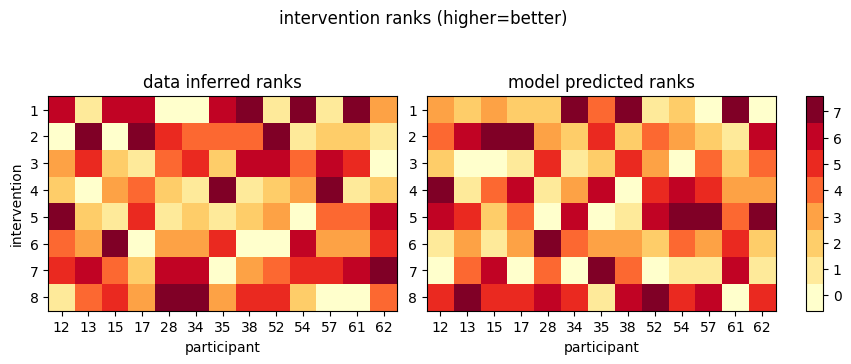

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotting_utils import discretized_colormap, subplots_with_colorbar
import numpy as np

L = len(intervention_names)
cmap = discretized_colormap('YlOrRd', L)
fig, axes = subplots_with_colorbar(data_ranks.loc[include_subj].T, model_ranks.T,
                                   share_all=True, cmap=cmap, aspect='equal',
                                   figsize=(10,4), cbar_ticks=np.linspace(0.5,6.5,8), cbar_ticklabels=range(L))
axes[0].set_ylabel('intervention')
axes[0].set_yticks(range(L), labels=np.arange(L)+1)
axes[0].set_xlabel('participant')
axes[0].set_xticks(range(len(model_ranks.index)), labels=model_ranks.index)
axes[0].set_title('data inferred ranks')
axes[1].set_xlabel('participant')
axes[1].set_title('model predicted ranks')
fig.suptitle('intervention ranks (higher=better)')

Plot the permutation of ranks

interactive1    3.000000e+00
interactive2   -2.000000e+00
interactive3    8.000000e-01
interactive4    2.200000e+00
interactive5    2.363636e+00
interactive6    1.500000e+00
interactive7    1.110223e-16
interactive8   -2.384615e+00
dtype: float64

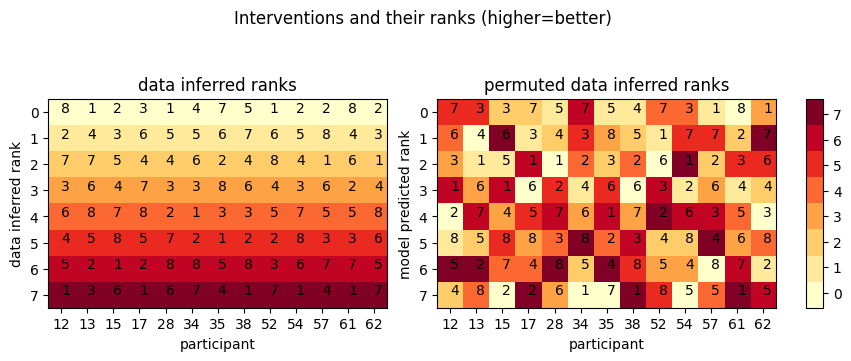

In [31]:
import matplotlib.pyplot as plt 

# fig, ax = plt.subplots(1,2, figsize=(10,4))

reordered_ranks = np.zeros((len(include_subj), L))
for j, p in enumerate(include_subj):
    reordered_ranks[j] = data_ranks.loc[p].loc[model_ranks.loc[p].sort_values().index].to_numpy()

cmap = discretized_colormap('YlOrRd', L)
fig, ax = subplots_with_colorbar(tc.arange(len(intervention_names)).repeat((len(model_ranks.index), 1)).T,
                       reordered_ranks.T,
                       figsize=(10,4), share_all=True, cmap=cmap, axes_pad=0.5,
                       cbar_ticks=np.linspace(0.5, L-1.5, L), cbar_ticklabels=range(L))

ax[0].set_xlabel('participant')
ax[0].set_ylabel('data inferred rank')
ax[0].set_xticks(range(len(include_subj)), labels=include_subj)
ax[0].set_yticks(range(L), labels=np.arange(L))
ax[0].set_title('data inferred ranks')
for pi, p in enumerate(include_subj):
    ordered_intervs = get_proximal_effects(p, until_timestep=until_timestep[p]).argsort().to_numpy() + 1
    for ii, i in enumerate(intervention_names):
        ax[0].annotate(str(ordered_intervs[ii]), (pi,ii))

ax[1].set_xlabel('participant')
ax[1].set_ylabel('model predicted rank')
ax[1].set_xticks(range(len(include_subj)), labels=include_subj)
ax[1].set_yticks(range(L), labels=np.arange(L))
ax[1].set_title('permuted data inferred ranks')
for pi, p in enumerate(include_subj):
    ordered_intervs = model_ranks.loc[p].argsort().to_numpy() + 1
    for ii, i in enumerate(intervention_names):
        ax[1].annotate(str(ordered_intervs[ii]), (pi,ii))

fig.suptitle('Interventions and their ranks (higher=better)')
get_proximal_effects('12', until_timestep=until_timestep['12'])

We can also visualize this as a scatter plot between predicted and actual effect, and calculate Kendall's tau

/tmp/ipykernel_3120756/3512059504.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tau = joint_df.groupby('participant').corr(method='kendall')['model predicted'].xs('data inferred', level=1)


Text(0.5, 0, 'participant')

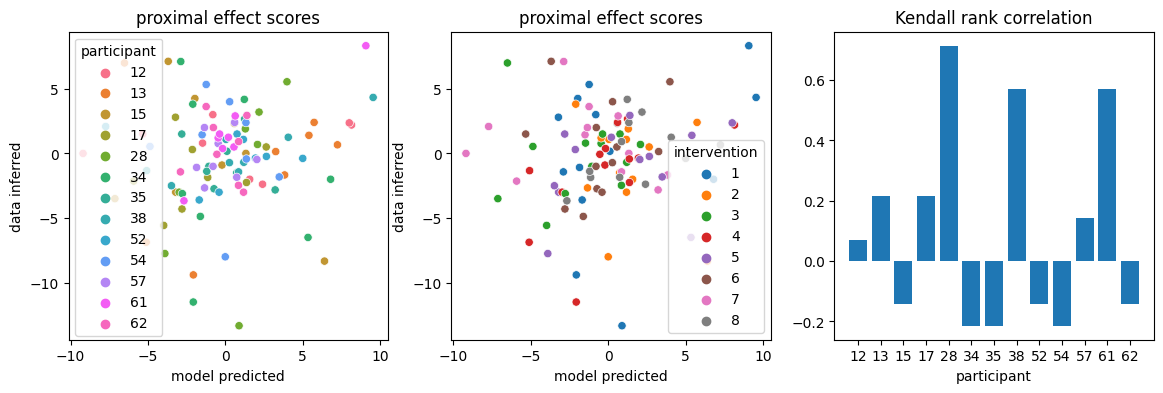

In [32]:
import seaborn as sns
from scipy import stats

participant_effects = model_predicted_effects.copy()
for p in include_subj:
    participant_effects.loc[p] = get_proximal_effects(p, until_timestep=until_timestep[p])
joint_df = pd.concat((model_predicted_effects.stack(), participant_effects.loc[include_subj].stack()), axis=1)
joint_df = joint_df.reset_index()
joint_df.columns = ('participant', 'intervention', 'model predicted', 'data inferred')
joint_df['intervention'] = joint_df['intervention'].str.slice(-1)
tau = joint_df.groupby('participant').corr(method='kendall')['model predicted'].xs('data inferred', level=1)

fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.scatterplot(data=joint_df, x='model predicted', y='data inferred', hue='participant', ax=axes[0])
axes[0].set_title('proximal effect scores')
sns.scatterplot(data=joint_df, x='model predicted', y='data inferred', hue='intervention', ax=axes[1])
axes[1].set_title('proximal effect scores')
axes[2].bar(tau.index, tau)
axes[2].set_title('Kendall rank correlation')
axes[2].set_xlabel('participant')